# **Import libraries**

Importing the basic necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import csv
import json

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Import dataset**

Loading the dataset into pandas dataframe.

In [3]:
dataset = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Final Coding/processed_reviews_split_surnamesS_minimal.csv")
df = pd.DataFrame(data = dataset)

# **Preparing exclusion dataset**

In [4]:
excluded_df = pd.DataFrame(data = dataset)

# initialising new columns in exclusion dataset
excluded_df['data_id']=excluded_df.review_id
excluded_df['excluded'] = '0'
excluded_df['reason_for_exclusion'] = 'N/A'

# preparing false verified data exclusion
for index in excluded_df.loc[excluded_df.verified == False].index:
  excluded_df.at[index,'data_id']=excluded_df.loc[index].review_id
  excluded_df.at[index,'excluded'] = '1'
  excluded_df.at[index,'reason_for_exclusion'] = 'Other'

# preparing -1 review score data exclusion
for index in excluded_df.loc[excluded_df.review_score == -1].index:
  excluded_df.at[index,'data_id']=excluded_df.loc[index].review_id
  excluded_df.at[index,'excluded'] = '1'
  excluded_df.at[index,'reason_for_exclusion'] = 'invalid'

# preparing nan type data exclusion
for index in df[~df.index.isin(df.dropna().index)].index:
  excluded_df.at[index,'data_id']=excluded_df.loc[index].review_id
  excluded_df.at[index,'excluded'] = '1'
  excluded_df.at[index,'reason_for_exclusion'] = 'missing_value_or_label'

exclusion_dataset = excluded_df[['data_id', 'excluded', 'reason_for_exclusion']]
exclusion_dataset.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Final Coding/exclusions_dataset_task4.csv", index = False)

# **Exploratory data analysis**

Understanding the components of data in the dataset like data types, data values, etc.

In [5]:
df.sample(15) # view random 15 data samples in dataframe

,review_id,text,verified,review_score,product_category,data_id,excluded,reason_for_exclusion
32585,product_review_032585,"Great value. Could use some improvements, but ...",True,4.0,musical_instruments,product_review_032585,0,N/A
17704,product_review_017704,DW makes great hardware (see my other reviews ...,True,4.0,musical_instruments,product_review_017704,0,N/A
4117,product_review_004117,The PSP reminds me of the iTunes software - ja...,False,2.0,video_games,product_review_004117,0,N/A
25833,product_review_025833,"Surprisingly good game! Great graphics, chall...",True,5.0,video_games,product_review_025833,0,N/A
28273,product_review_028273,If only they included a sync-start. Could trig...,False,4.0,musical_instruments,product_review_028273,0,N/A
26829,product_review_026829,"<div id=""video-block-R2C1IBMVC8M01U"" class=""a-...",True,5.0,musical_instruments,product_review_026829,0,N/A
32580,product_review_032580,This is a game. What can I say? I don't play ...,True,4.0,video_games,product_review_032580,0,N/A
13594,product_review_013594,"This is an excellent game, but not one that yo...",True,4.0,video_games,product_review_013594,0,N/A
9007,product_review_009007,Really didn't know what to expect with this ga...,False,5.0,video_games,product_review_009007,0,N/A
8811,product_review_008811,Can't stop playing it..,False,5.0,video_games,product_review_008811,0,N/A


In [6]:
# view total number of rows and column in dataset
print("The rows x column present in dataset is: ", df.shape)

The rows x column present in dataset is:  (32917, 8)


In [7]:
# view the categorical data and their count in the dataset
from IPython.display import HTML
def pretty_print_df(value_counts_):
  "Quick function to display value counts more nicely"
  display(HTML(pd.DataFrame(value_counts_).to_html()))

# all categorical features
categorical_columns= ['verified', 'review_score', 'product_category']

# get the categories and their count for each feature
for col in categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  pretty_print_df(df[col].value_counts())
  print()

Categories and number of occurrences for 'verified'


,verified
True,23511
False,9292



Categories and number of occurrences for 'review_score'


,review_score
5.0,19270
4.0,6203
3.0,3116
1.0,1875
2.0,1546
-1.0,907



Categories and number of occurrences for 'product_category'


,product_category
video_games,21852
musical_instruments,10159


In [8]:
# number of missing values per column
df.isna().sum()

review_id                 0
text                     13
verified                114
review_score              0
product_category        906
data_id                   0
excluded                  0
reason_for_exclusion      0
dtype: int64

# **Data cleaning**

Cleaning dataset based on the exploratory data analysis report. Following processes are executed for cleaning the dataset:


*   Removing the negative review score of -1
*   Removing rows with nan type datapoints
*   Removing the rows with false verified data
*   Dropping the unused columns
*   Removing the html tags, urls, symbols, etc. from data


> ***Note:** Last section shows the exploratory data analysis for textual data where spacy is used for showing the text length distribution and bag of words with frequency visualisation.



In [9]:
# replace negative review_score with NaN 
df.loc[df.review_score<0,'review_score'] = np.nan

In [10]:
# Number of missing values per column
df.isna().sum()

review_id                 0
text                     13
verified                114
review_score            907
product_category        906
data_id                   0
excluded                  0
reason_for_exclusion      0
dtype: int64

In [11]:
# remove all rows with missing data
print(f'Original dataset length: {len(df)}')
df_reduced = df.dropna()
print(f'Dataset length after removing missing rows: {len(df_reduced)}')
print()

Original dataset length: 32917
Dataset length after removing missing rows: 30983



In [12]:
# remove rows where verified is false

df_reduced = df_reduced.drop(df_reduced[df_reduced.verified == False].index)


In [13]:
print(f'Dataset length after removing false verified rows: {len(df_reduced)}')

Dataset length after removing false verified rows: 22206


In [14]:
# remove multiple selected columns

df_cleaned = df_reduced.drop(["review_id", "verified"], axis=1)


In [15]:
# imports for text cleaning
import re
import nltk
import string
from nltk.corpus import stopwords

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# cleaning stop words, html tags, urls, etc. from data
from lxml import html
from bs4 import BeautifulSoup

stop_words = stopwords.words("english")

def text_preproc(x):
  x = x.lower()
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  x = x.encode('ascii', 'ignore').decode()
  # x = str(html.fromstring(x).text_content())
  soup = BeautifulSoup(x, 'lxml')
  x = soup.get_text()
  x = soup.get_text()
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  
  return x

df_cleaned['text'] = df_cleaned.text.apply(text_preproc)

# **Preparing spacy corpus to explore dataset**

In [18]:
# importing spacy 

# !pip install --upgrade spacy

# spacy needs language models - let's make sure they are downloaded
# !python -m spacy download en_core_web_md

In [19]:
import spacy

# Create an NLP pipeline
nlp = spacy.load('en_core_web_md') #add mention to other languages
cleandf_spacy = list(nlp.pipe(df_cleaned['text']))

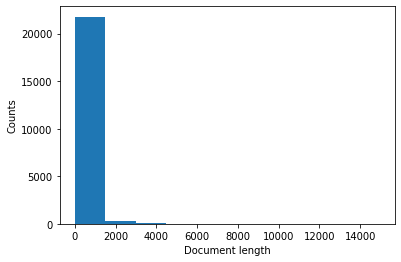

In [20]:
# text length distribution
# get the lenght of all processed documents in the training dataset
train_doc_lengths= []
for doc in cleandf_spacy:
  train_doc_lengths.append(len(doc.text)) #doc.text contains the whole text of the original document


import matplotlib.pyplot as plt
# plot the distribution of lengths in an histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(train_doc_lengths)
ax.set_xlabel('Document length')
_ =ax.set_ylabel('Counts')


**Bag of words - visualising the words and their occurrence**

In [21]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# create a tokenizer that leaves documents already tokenized as they are:
def tokenize_as_is(x):
  ''' x is a list of tokens. It's returned as is'''
  return x

# define a function to get the most frequent ngrams
def get_top_ngram(spacy_tokenized_corpus, ngram_range=(1,2), top_n= 50):
    ''' By default it return the top 50 unigrams/bigrams'''
    vec = CountVectorizer(ngram_range=ngram_range, max_features=top_n, lowercase=False,
                          tokenizer=tokenize_as_is).fit(spacy_tokenized_corpus)
    # get a vector for each document
    bag_of_words = vec.transform(spacy_tokenized_corpus)
    # sum across documents
    sum_words = bag_of_words.sum(axis=0) 
    # get the words with their frequencies and order them
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return bag_of_words, words_freq#[:10]

In [22]:
df_tokenized = []
for i,doc in enumerate(cleandf_spacy):
  # let's collect all valid tokens (i.e. no stop words, no punctuation) into a list
  df_tokenized.append([token.lemma_ for token in doc if not (token.is_stop or token.is_punct)])



/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


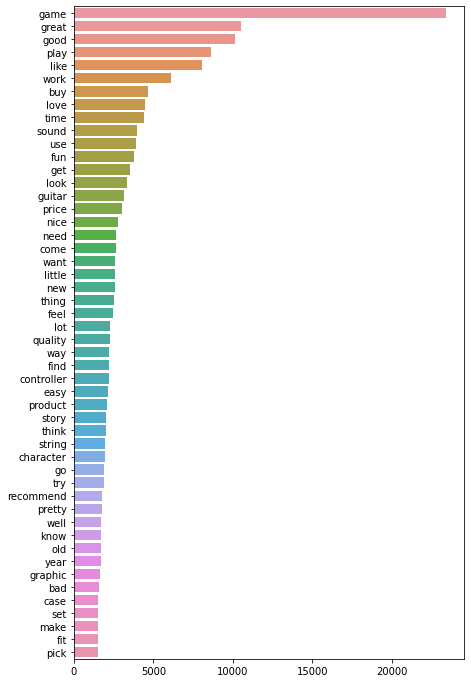

In [23]:
# let's get the words frequencies
bag_of_words, words_freq= get_top_ngram(df_tokenized, ngram_range=(1,2), top_n= 50)

# let's plot them
import seaborn as sns
# separate the n_grams from their frequencies
ngram_labels = [word[0] for word in words_freq]
ngram_freqs = [word[1] for word in words_freq]
plt.figure(figsize=(7,12))
sns.barplot(x=ngram_freqs,y=ngram_labels)


# **Preprocessing**

Vectorizing the text data with TfidfVectorizer and performing train test slipt twice for classifying review score and product category for two different models.

In [24]:
# importing vectorizer and train test split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [25]:
# initialising TfidVectorizer
tfidf = TfidfVectorizer()

**For Linear SVM**

In [26]:
# assigning the dataset for train test split for classifying review score
X_lsvc = tfidf.fit_transform(df_cleaned['text'])
y_lsvc = df_cleaned['review_score']

In [27]:
# checking the shape of vectorized dataset
X_lsvc.shape, y_lsvc.shape

((22206, 29254), (22206,))

In [28]:
# train test split
X_lsvc_train, X_lsvc_test, y_lsvc_train, y_lsvc_test = train_test_split(X_lsvc, y_lsvc, test_size = 0.2, random_state = 0)

In [29]:
# checking the shape of training dataset
X_lsvc_train.shape

(17764, 29254)

**For Multinomial Naive Bayes**

Multinomial Naive Bayes model is used for predicting the product category. To do so, product category, 'musical instrument' is taken as '0' and video games is taken as '1'.

*   Converting musical instument and video games categories as 0 and 1 respectively to make prediction easy
*   Train test split for predicting product category

In [30]:
# representing product category in new column with numberical values
df_cleaned["product_category_lebel"] = pd.Series(df_cleaned["product_category"].apply(lambda cat : 1 if str(cat) == 'video_games' else 0))

In [31]:
# assigning the dataset for train test split for classifying review score
X_nb = tfidf.fit_transform(df_cleaned['text'])
y_nb = df_cleaned['product_category_lebel']

# train test split
X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(X_nb, y_nb, test_size = 0.2, shuffle=True, random_state=None)

In [32]:
# checking the shape of training dataset
X_nb_train.shape

(17764, 29254)

# **Modelling**

## **Model 1: Linear SVM**

In [33]:
from sklearn.svm import LinearSVC 
from sklearn.utils import class_weight

lsvc = LinearSVC(C = 10, class_weight = 'balanced')
lsvc.fit(X_lsvc_train, y_lsvc_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=10, class_weight='balanced')

## **Multinomial Naive Bayes**

In [34]:
from sklearn import naive_bayes

nb = naive_bayes.MultinomialNB()
nb.fit(X_nb_train, y_nb_train)

MultinomialNB()

# **Model Evaluation**

## **Linear SVM**

**Classification Report**

In [35]:
from sklearn.metrics import classification_report

y_lsvc_predicted = lsvc.predict(X_lsvc_test)
print(classification_report(y_lsvc_test, y_lsvc_predicted))

              precision    recall  f1-score   support

         1.0       0.48      0.42      0.45       216
         2.0       0.20      0.18      0.19       182
         3.0       0.24      0.25      0.25       386
         4.0       0.32      0.34      0.33       782
         5.0       0.79      0.78      0.79      2876

    accuracy                           0.62      4442
   macro avg       0.41      0.39      0.40      4442
weighted avg       0.62      0.62      0.62      4442



**Confusion Matrix**

In [36]:
from sklearn.metrics import confusion_matrix
# confusion matrix for test data prediction
confusion_matrix(y_lsvc_test, y_lsvc_predicted)

array([[  91,   34,   23,   28,   40],
       [  25,   32,   49,   19,   57],
       [  21,   35,   97,  104,  129],
       [  21,   13,  101,  266,  381],
       [  33,   43,  135,  409, 2256]])

## **Multinomial Naive Bayes**

**Accuracy Score**

In [37]:
from sklearn.metrics import accuracy_score

y_nb_predicted = nb.predict(X_nb_test)
print(accuracy_score(y_nb_test, y_nb_predicted))

0.9108509680324178


**Classification Report**

In [38]:
print(classification_report(y_nb_test, y_nb_predicted))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1786
           1       0.89      0.97      0.93      2656

    accuracy                           0.91      4442
   macro avg       0.92      0.90      0.90      4442
weighted avg       0.91      0.91      0.91      4442



**Confusion Matrix**

In [39]:
# confusion matrix for test data prediction
confusion_matrix(y_nb_test, y_nb_predicted)

array([[1458,  328],
       [  68, 2588]])

## **Interchanging model to classify target values**

**Classifying review score by Multinomial Naive Bayes**

In [40]:
# fitting review score data in naive bayes
alt_nb = naive_bayes.MultinomialNB()
alt_nb_review_score = alt_nb.fit(X_lsvc_train, y_lsvc_train)

review_score_nb_predicted = alt_nb_review_score.predict(X_lsvc_test)

# accuracy of review score prediction by multinomial naive bayes
print("Accuracy on review score by Naive Bayes: ")
np.mean(review_score_nb_predicted == y_lsvc_test)

Accuracy on review score by Naive Bayes: 


0.6470058532192706

In [41]:
print("Accuracy on review score by Linear SVM: ")
np.mean(y_lsvc_predicted == y_lsvc_test)

Accuracy on review score by Linear SVM: 


0.6172895092300765

**Classifying product category by Linear SVM**

In [42]:
# fitting product category data in linear svm
alt_lsvc = LinearSVC(C = 10, class_weight = 'balanced')
alt_lsvc_product_category = alt_lsvc.fit(X_nb_train, y_nb_train)

product_category_lsvc_predicted = alt_lsvc_product_category.predict(X_nb_test)

# accuracy of product category prediction by linear svm
print("Accuracy on product category by Linear SVM: ")
np.mean(product_category_lsvc_predicted == y_nb_test)

Accuracy on product category by Linear SVM: 


0.904997748761819

In [43]:
print("Accuracy on review score by Multinomial NB: ")
np.mean(y_nb_predicted == y_nb_test)

Accuracy on review score by Multinomial NB: 


0.9108509680324178

# **Model Prediction Testing** 

## **Linear SVM**

Testing the live sample data copied from the amazon website for predicting the star rating. Section below shows the Original star rating in amazon website and that predicted by the model.

In [44]:
sample_data_lsvc = pd.Series(["You can barely hear the sound! And the headphone jack barely works, you can only faintly hear yourself! Honestly if you want a mic, i don’t think this mic is worth the money",
                "Perfect rig for those looking to start sim racing, it has transformed our racing since it’s been set up! A really great experience at a good price. It is really easy to adjust everything on the seat and pedals and it was also easier to assemble than expected. Would definitely recommend",
                "I was one of the first people in the UK to get hold of the very original PS1, so that makes me old I know. However my memory isn't that bad, I loaded and tried to play Tekken 3 and Ridge Racer 4 and a few others. They did load, albeit having to wait for them to load. But the frame rate, blurry pixels (no not quite my eyesight yet) no up-scaling, borders on the edge no fancy rendering made my heart sink. This is terrible. GTA has truly awful emulation. I know things have moved on, but the emulation was horrible. I was not expecting HD remasters of every single game, but a lot of them had issues with sound and frame rates and general unresponsiveness. Never have I been so disappointed. Maybe I should have waited for these reviews, I definitely would not have bought it. I do NOT recommend this item however tempting it sounds. Honestly you are better off sourcing the originals and getting a PS3 or a PS2 that can play PS1 games. On paper a brilliant concept, in practice dreadful implementation. EDIT: Why on earth didn't I just buy a PS One, it's only about 5cm wider and longer than this and can be found for about £20 with a power adaptor but no games. EDIT2: Paid £90 when it came out and it is already down to £50 in the New Year Sales. EDIT3: Has powered itself off twice now. I suggest saving every hour or so. Concerned now with the long term quality of this item. Fed up with it now and decided to open it up, the large passive heat-sink sits on the main CPU/GPU I imagine that it powered off due to overheating. Heading for the dustbin!!",
                "I can’t understand people complaining about 20 games, their favourite not being on here, no dualshock or not being able to change discs. (It’s almost smaller than a disc). If they refer to the disc changer button, that does work on games (that had multiple discs) when you are up to the part in tha game where a disc change is needed.... FF7 etc. I read about this on the Sony website before I bought it. Also it seems people may have forgotten that this is an old console and their phones are more powerful. So the games are a little scruffy in parts and frames dropped on the original. The graphics aren’t amazing. They weren’t in 1995. I don’t like 100% of the games. So I don’t play them. I do love some of the games and these run well, look good, play well and I’m happy I bought it. Like the nes and snes. Some games aren’t ones you will like. You can’t add or take any away (unless it’s hacked). Like those “consoles”, it’s an emulator. It’s not an actual console. It’s a piece of nostalgia. (Memberberries) And for that it does a good job. Any company making one would be accused of Ripping off Nintendo. Research before you buy. I bought it when it was just a few games revealed and knew their were no dualshocks. It’s not perfect. But it’s fun to play the old games with old style controllers. (Update) I’ve had a few comments on this review so I thought I’d respond. Their comments are all correct and I thank them for posting. Analysis has shown this does not perform as well as the original. In some cases 3 FPS are dropped, in other case 10 FPS (from 60-50). In some cases the sounds is off and the visuals blurred. Though I must say without sarcasm. When I play it. I don’t play it with FAPS counting the frames per second. I don’t play it side by side with the original to make comparison. I do play it for the games and I still enjoy it. (Personal opinion). Statistics are good and correct. But I didn’t buy it for stats. The SNES mini also drops frames , sounds are off and has some colour changes to the original. Also facts by analysis by better people than I. But I must admit not as noticeable as the PS classic. My point being it’s not perfect, especially if compared statistically and side by side. It could have been better and would have been nice if it was a perfect recreation. I just play mine. And I enjoy it.",
                "I wanted to love it. All of the beautiful design touches from the original PlayStation are there and it looks fantastic. But fire it up and it's really quite bad. The games run passably well, but there are random unexpected graphical and audio hitches that make the overall experience unpleasant. Example, Final Fantasy VII seems to struggle from the start. Then, as the action on screen heats up, the graphics turn muddy, the controls get laggy and the audio stretches out weirdly. The first combat sequence hammers home the fact that the PlayStation Classic is not the best place to be playing this game. On a slightly more positive note the PlayStation Classic features save states. Which is a good thing. You can hit the Reset button at any point and the console will dump a save state for you to pick up exactly where you left off the next time you load the game. But there's only one save state per game. Which isn't a good thing. Multiple saved games are an option but menu navigation and the original PlayStation save mechanics mean that you'll be wasting a whole bunch of time when compared to save states. I'm not sure I dare even mention the game selection. I'll leave it at this: the included games make me feel like I'm playing PlayStation round at someone else's house and they don't have any of the 'cool games'. The controllers look the part but having become so used to playing video games using analogue sticks returning to movement using the D-Pad feels super awkward. There are already lead extenders available for the PlayStation Classic but I found that the Amazon basics USB extender cable does the job just fine. The box includes two leads. One is a good quality HDMI cable. The other is a fairly short Micro USB power cable. I found I was able to power the PlayStation Classic via my TV's USB socket, which was fortunate because Sony decided against including a dedicated mains USB plug. For the hefty price tag the PlayStation Classic is a let down on multiple fronts. It's a beautiful piece of plastic but that's not enough to justify the £90 price tag.",
                "A lot of people moaned about the games and speed of this console. In my opinion the games that came pre-installed were actually quite good and contained a good selection of my favourite games. The emulation was also good and most of the complaints were that they used PAL games not NTSC since NTSC has a faster frame rate. But since I am in the UK the games look and play exactly as I remember them. But if that wasn't enough for you then plug in a USB stick and run BleemSync on it. Now you can change the emulator settings to render everything in higher resolution and add as many games as you like to the console. The mods are getting better by the day! It can also run all other emulator cores (N64, SNES, NES, Medgadrive etc). For £49.99 (Current Price at time of review) this really is a great piece of it!."])

td_vec = tfidf.transform(sample_data_lsvc)
predicted_lsvc = lsvc.predict(td_vec)
alt_predicted_nb = alt_nb_review_score.predict(td_vec)

print("Original star rating sequence: ")
print("3")
print("5")
print("1")
print("4")
print("2")
print("5")

print("")
print("-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-")


print("Predicted star rating sequence: ")

print("By Linear SVM: ")
for a in predicted_lsvc:
  print(a)

print("")
print("-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-")
print("By Multinomial Naive Bayes: ")
for a in alt_predicted_nb:
  print(a)

Original star rating sequence: 
3
5
1
4
2
5

-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-
Predicted star rating sequence: 
By Linear SVM: 
3.0
5.0
3.0
4.0
3.0
4.0

-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-
By Multinomial Naive Bayes: 
5.0
5.0
5.0
5.0
5.0
5.0


## **Multinomial Naive Bayes**

Testing the live sample data copied from the amazon website for predicting the product category. Section below shows the Original product category in amazon website and that predicted by the model.

In [45]:
sample_data_nb = pd.Series(["Bought this as my 5yr old son took an interest in my guitar playing and wanted one of his own. Overall finish and build quality is quite bad, the neck is also very thick for a child's guitar. However, with some effort it can hold its tune with only a little fret buzz, so I guess for the price it is acceptable. While it is an economical way to introduce your kid/grandkid to guitar (my son has already learn a could of simple songs), if they are really serious I would suggest you save your money and take them in to a local guitar shop to get a proper new/secondhand instrument. One of the main issues of concern, in terms of build quality, is that there appears to be some separation between the bridge and the main body. We will be monitoring this over time to see if it progresses, as complaints from many of the other reviewers say this is where string tension caused the guitar to break.", 
               "I got this to teach my daughter to play. I actually got this to gauge her willingness as I didn’t want to get a more expensive one if it was another one of her whims. It was as it turns out, but this guitar was pretty awful. It’s reminiscent of a classical guitar but lacks the finish of anything good - but then at this price that’s not really a criticism. My chief issue was the tuning and intonation were dreadful and it has a horrible fretboard. I had the misfortune of having to restring it (my daughter is left handed) and it was a frustrating and messy experience at best. Though again, at this price... I guess it’s a good price to see if a spark of interest is there before you get a proper guitar. But to learn with full time. Nah.", 
               "Bought this for my little 5 year old grandson’s birthday. It arrived promptly, was well packaged with a spare set of nylon strings, so far so good. When I tuned it up and tried to play it, found it impossible. The strings at the first fret were so high it was unplayable. I examined the Nut and found it was misaligned to the fret board and was also higher at one side than the other. Rather than returning it I decided to fix it myself. I removed the Nut, cut a more level channel in the headstock, shaved the nut by a millimetre or two and refitted. Now much better, strings are where they should be and it is lovely to play. If there is a quality control department at the factory they should be sacked and replaced, But for £20 it is good value and hopefully I was just unlucky with this example.",
               "I'm going to state this plain and simple. This product is potentially hazardous. When this guitar was tuned to standard tuning the bridge catapulted from the body at considerable force. It narrowly missed my face and could have caused serious injury. I dread to think what would have happened if I was a small child holding this thing. Please if you are considering this for your child's first guitar then don't, just don't. It's like this:- a small crossbow generates about 100lbs of force and a standard tuned guitar about 75 to 85 lbs of force. Do the maths! On closer inspection the bridge was attached with two screws that were drilled into a soft and thin bit of wood. This product is an accident waiting to happen.",
               "If I didn’t know any different I would suspect this to be a fake. The adaptive trigger effects are weak at best, vibration is poor and the controller speaker crackled and is now at a constant barely audible level. It looks and feels genuine but having all these issues makes me think it’s either a poor batch of controllers or is a fake. Have ordered a replacement and will update this review accordingly with that.",
               "Recommendation: buy the PS4 version and play that on the PS5. It's the same game but cheaper, and even then wait for the price to come down. Review. This isn't as good as the original. I'm about 10 hours in. I've got past the must do activities and now I'm in the Forbidden West proper. And somehow I don't really care. The graphics are probably better than on the PS4 but not in any meaningful way. There's more detail and more leaves, dust and bugs in the air but nothing that adds to the game play. The cut scenes - of which there are many and they are often long - are beautiful but so what? I don't buy games to watch very high quality mini-films. The game play feels clunky and a bit awkward. Compared to AC Valhalla it feels very dated. The hand-to-hand combat in particular feels weird. During one must-win-to-progress fight the 'champion' eventually just stood still while I beat him up! And it's buggy. I've been stuck in the undergrowth twice. Machines have been able to put their heads through 'solid' objects. I don't remember any of these problems with the original - which I played through twice. Finally there's no build in the 'plot', it just doesn't pull you in to the game. And one final thing ... when are we going to get a true PS5 game, not just a PS4 game with updated graphics? Yes the PS5 is bigger, faster and so on, but at the moment it just feels like a supped-up PS4. Overall I would recommend waiting for the price to drop - a lot. Definitely not worth £70 or anything close. xxxx Update: lost 10 levels due to a save fail. Really weird because it took me back a couple of days, not to the last session, and not to the last quick save. Known bug? I've stopped playing the game.",
               "The game should be here right now, hell should've arrived yesterday. Wont pre order from amazon ever again. Rather just buy digital next time. Everyone is playing right now but ofc i have to wait. Its nearly 2 pm, order isnt on its way yet. Im lucky if i get it by the evening. What the hell man..",
               "So far I am finding this game to be incredible, I'm about 10 hours in and can already tell that I will sink well over 100 hours into this game, maybe nearer to 150, and that'll likely be on just1 play-through. It looks incredible, the scenery is captivating, colours are powerful and vibrant, the atmosphere is so alive and the environment just really pulls you into a beautiful rendition of a post-apocalyptic, over-grown world. The story leads on immediately from Zero Dawn in a great way, and I am looking forward to seeing what the story will uncover next! There looks to be an abundance of side-quests and other missions/tasks, as well as customisations and options for multiple styles of play! Definitely worth a pickup for any RPG fan, but especially for fans of the first game! There's no point reviewing Amazon's delivery service, the high winds in the South of the UK meant that all shipments for 18th Feb were delayed, so I did received this game on the 19th, despite the tracking not working. For obvious reasons, I will forgive Amazon completely for this as they have no control over the weather, and I am very grateful I managed to receive the game on the following day despite there still being fairly high winds all weekend."])

predict_sample_data_nb = tfidf.transform(sample_data_nb)
predicted_nb = nb.predict(predict_sample_data_nb)
alt_predicted_lsvc = alt_lsvc_product_category.predict(predict_sample_data_nb)

print("Original product category sequence: ")
print("")
print("Musical Instrument")
print("Musical Instrument")
print("Musical Instrument")
print("Musical Instrument")
print("Video Games")
print("Video Games")
print("Video Games")
print("Video Games")

print("")
print("-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-")
print("")

print("Predicted product category sequence by Linear SVM: ")

for a in alt_predicted_lsvc:
  if a == 0:
    print("'Musical Intrument'")
  else:
    print("'Video Games'")

print("")
print("-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-")
print("")
print("Predicted product category sequence by Multinomial NB: ")
for a in predicted_nb:
  if a == 0:
    print("Musical Instrument")
  else:
    print("Video Games")

Original product category sequence: 

Musical Instrument
Musical Instrument
Musical Instrument
Musical Instrument
Video Games
Video Games
Video Games
Video Games

-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-

Predicted product category sequence by Linear SVM: 
'Musical Intrument'
'Musical Intrument'
'Musical Intrument'
'Musical Intrument'
'Musical Intrument'
'Video Games'
'Video Games'
'Video Games'

-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-

Predicted product category sequence by Multinomial NB: 
Video Games
Video Games
Musical Instrument
Musical Instrument
Video Games
Video Games
Video Games
Video Games
